In [0]:
!pip install tensorflow==1.15

## Grad-CAM

[Code](https://www.hackevolve.com/where-cnn-is-looking-grad-cam/)

[Explanation](https://fairyonice.github.io/Grad-CAM-with-keras-vis.html)

Let Ak∈ℝu x v be the kth feature map (k=1,⋯,K) from the last convolutional layer. The dimension of this feature map is height u and width v. For VGG16, u=14, v=14, K=512. 

* Convolutional feature map retain spatial information
* Each kernel in the feature map represents some sort of visual information
* And each pixel in the feature map indicates whether the corresponding kernel's visual patterns are active in its receptive field
> `yc=f(A1,...,A512)`
* The spatial class score could be represented as a linear combination of the feature map with some weights
![Grad-CAM](https://i.imgur.com/GT3nS4v.png)

## Importing Libraries

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [0]:
vgg = VGG16(weights="imagenet")

In [5]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
!wget -O dog.jpeg https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/most-loyal-dog-breeds-st-bernard-1571189105.jpg

In [0]:
!wget https://raw.githubusercontent.com/akshaychawla/Occlusion-experiments-for-image-segmentation/master/imagenet_class_index.json

In [0]:
img = load_img("dog.jpeg", target_size=(224, 224))

(-0.5, 223.5, 223.5, -0.5)

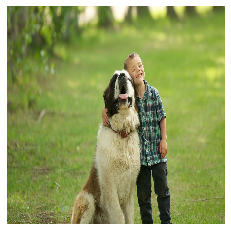

In [7]:
plt.imshow(img)
plt.axis("off")

In [0]:
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

In [9]:
x.shape

(1, 224, 224, 3)

In [10]:
pred = vgg.predict(x)
pred_idx = np.argmax(pred[0])
print(f"Predicted Class Index: {pred_idx}")

Predicted Class Index: 331


In [11]:
with open("imagenet_class_index.json", "rt") as f:
  imagenet_labels = json.load(f)
pred_class = imagenet_labels[str(pred_idx)][1]
print(f"Predicted Class: {pred_class}")

Predicted Class: hare


### Gradient Calculation

Calculating the gradient of the class output w.r.t convolution feature map

In [0]:
# # trial 1
# with tf.GradientTape() as tape:
#   grads = tape.gradient(class_output, conv_feat)[0]

# # trial 2
# last_conv_layer = vgg.get_layer('block5_conv3')
# with tf.GradientTape() as tape:
#   pred = vgg.predict(x)
#   pred_idx = np.argmax(pred[0])
#   class_output = vgg.output[:, pred_idx]
#   grads = tape.gradient(class_output, last_conv_layer.output)

In [0]:
preds = vgg.predict(x)
class_idx = np.argmax(preds[0])
class_output = vgg.output[:, class_idx]
last_conv_layer = vgg.get_layer("block5_conv3")

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([vgg.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [0]:
img = cv2.imread("dog.jpeg")
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

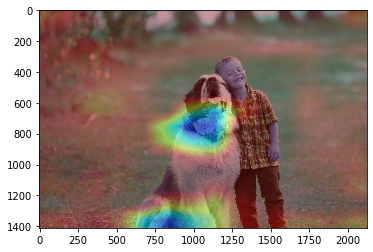

In [34]:
plt.imshow(superimposed_img, cmap="jet")